## Variational Autoencoder

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  #[-1, 1]
])

train_dataset = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 8.85MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 138kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 2.51MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 9.79MB/s]


In [ ]:
# Defining VAE model
class VAE(nn.Module):
    def __init__(self, latent_dim=12):
        super().__init__()
        self.latent_dim = latent_dim

        # Encoder layers
        self.enc1 = nn.Linear(784, 256)
        self.enc2 = nn.Linear(256, 2*latent_dim)  # Output mean and logvar

        # Decoder layers
        self.dec1 = nn.Linear(latent_dim, 256)
        self.dec2 = nn.Linear(256, 784)

    def encode(self, x):
        x = x.view(-1, 784)
        h = F.relu(self.enc1(x))
        return self.enc2(h).chunk(2, dim=1)  # Split into mean and logvar

    def decode(self, z):
        h = F.relu(self.dec1(z))
        return torch.tanh(self.dec2(h)).view(-1, 1, 28, 28)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

# Initialize model
vae = VAE().to(device)

In [ ]:
# Training function
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

for epoch in range(20):
    total_loss = 0
    for imgs, _ in train_loader:
        imgs = imgs.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = vae(imgs)

        # Reconstruction loss
        recon_loss = F.mse_loss(recon, imgs, reduction='sum')
        # KL divergence
        kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        loss = recon_loss + kl_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {total_loss/len(train_dataset):.4f}')

Epoch 1, Loss: 92.1274
Epoch 2, Loss: 73.1310
Epoch 3, Loss: 70.2650
Epoch 4, Loss: 68.7164
Epoch 5, Loss: 67.6744
Epoch 6, Loss: 66.8662
Epoch 7, Loss: 66.3176
Epoch 8, Loss: 65.8086
Epoch 9, Loss: 65.4042
Epoch 10, Loss: 65.0388
Epoch 11, Loss: 64.7729
Epoch 12, Loss: 64.4959
Epoch 13, Loss: 64.2995
Epoch 14, Loss: 64.0687
Epoch 15, Loss: 63.8931
Epoch 16, Loss: 63.7376
Epoch 17, Loss: 63.5579
Epoch 18, Loss: 63.4304
Epoch 19, Loss: 63.2948
Epoch 20, Loss: 63.2098


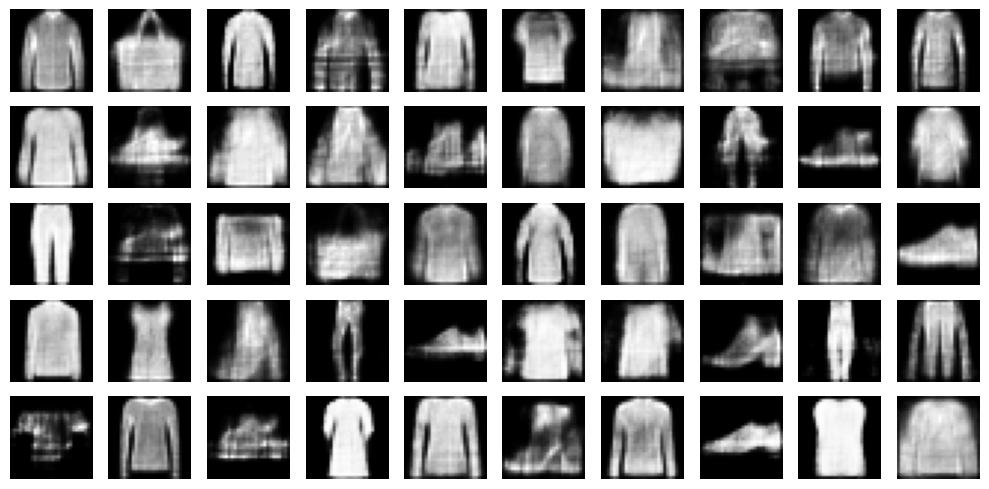

In [ ]:
# Generate new samples
with torch.no_grad():
    z = torch.randn(50, 12).to(device)
    samples = vae.decode(z).cpu()

# Plot generated images
plt.figure(figsize=(10,5))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.imshow(samples[i].squeeze().numpy()*0.5+0.5, cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()

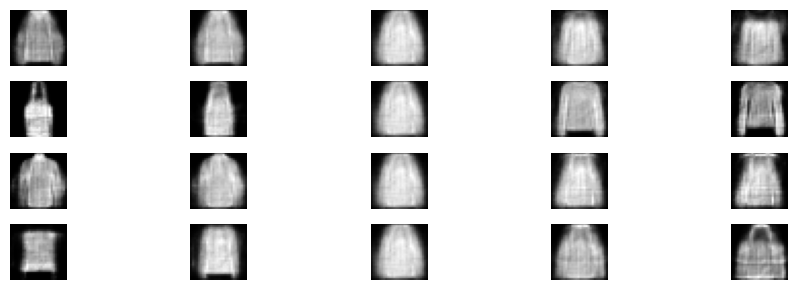

In [ ]:
# Bonus: Tweak latent dimension
z_base = torch.zeros(1, 12).to(device)
values = torch.linspace(-3, 3, 5)

plt.figure(figsize=(10,3))
for dim in range(4):
    for i, val in enumerate(values):
        z = z_base.clone()
        z[0, dim] = val
        with torch.no_grad():
            img = vae.decode(z).cpu()

        plt.subplot(4,5, dim*5+i+1)
        plt.imshow(img.squeeze().numpy()*0.5+0.5, cmap='gray')
        plt.axis('off')
plt.tight_layout()
plt.show()

The VAE successfully learns to generate novel fashion items, with some blurriness common in VAEs. The latent space manipulations show meaningful feature variations, indicates the model has learned useful representations.
